In [7]:
import os, sys, numpy as np, time, random, warnings
import matplotlib.pyplot as plt

# Set up the source path (adjust as needed for your project)
notebooks_path = os.path.abspath(os.getcwd())
src_path = os.path.abspath(os.path.join(notebooks_path, "../src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Import your custom functions (ensure these are accessible in your PYTHONPATH)
# Import your custom functions (including the markovian solvers)
from optimal_code.utils import *
from optimal_code.optimal_solver import *
from optimal_code.optimal_solver_markov import *
from trees.build_trees_from_paths import *
# Import modules
from trees.multi_dimension.Multidimension_trees import *
from trees.multi_dimension.Multidimension_solver import *
from trees.multi_dimension.Multidimension_adapted_empirical_measure import *
from adapted_empirical_measure.AEM_grid import *
from benchmark_value_gaussian.Comp_AWD2_Gaussian import *
from adapted_empirical_measure.AEM_grid import *
from trees.tree_Node import *
from trees.treeAnalysis import *
from trees.treeVisualization import *
from trees.tree_AWD_utilities import *
from trees.build_trees_from_paths import build_tree_from_paths
from trees.awd_trees.Discrete_OT_Solver_algo import *
from trees.awd_trees.Nested_Dist_Algo import *

from optimal_code.utils_multidim import *
from optimal_code.optimal_solver_multidim import *

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)



In [17]:
sample_sizes = [1000, 2000, 4000, 6000, 10000, 15000, 20000]
fixed_grid = 0.5
n_runs = 10

# Define matrices (dimension 4)
L = np.array([[1, 0, 0, 0],
              [1, 2, 0, 0],
              [1, 2, 3, 0],
              [1, 2, 3, 4]])
M = np.array([[1, 0, 0, 0],
              [2, 1, 0, 0],
              [3, 2, 1, 0],
              [4, 3, 2, 1]])


# Parameters
d = 2
T = 2
dim = d * T

a, b = np.zeros(dim), np.zeros(dim)

## I need to put the kmeans stuff here

In [19]:
results = {}  # Dictionary to store results keyed by sample size

for n_sample in sample_sizes:
    distances_runs = np.zeros(n_runs)
    times_runs = np.zeros(n_runs)
    
    print(f"\nRunning experiments for sample size: {n_sample}")
    
    for run in range(n_runs):
        # Generate two different random seeds (one for each matrix)
        seed1 = np.random.randint(10000)
        #seed2 = np.random.randint(10000)
        #while seed2 == seed1:  # Ensure they are different
            #seed2 = np.random.randint(10000)
        
        # Generate sample paths:
        # Process X (using matrix L) with seed1
        X, A = Lmatrix2paths_flat(L, n_sample, d, T, seed=seed1, verbose=False)
        Y, B = Lmatrix2paths_flat(M, n_sample, d, T, seed=seed1, verbose=False)
        
        # Compute the theoretical benchmark distance
        benchmark = adapted_wasserstein_squared_multidim(a, A, b, B, d, T)
        
        # Convert paths to adapted versions using the fixed grid
        adaptedX = path2adaptedpath_multidim(X, delta_n=fixed_grid)
        adaptedY = path2adaptedpath_multidim(Y, delta_n=fixed_grid)
        
        # Build quantization mapping:
        # Reshape the data so that we obtain a list of all ℝ² points:
        # adaptedX: shape (T+1, n_sample, d) -> (n_sample, T+1, d)
        points_X = adaptedX.transpose(1,0,2).reshape(-1, d)
        points_Y = adaptedY.transpose(1,0,2).reshape(-1, d)
        # Use np.unique along axis=0 to get unique grid points in ℝ².
        q2v = np.unique(np.concatenate([points_X, points_Y], axis=0), axis=0)
        # Convert each unique row (a 2D vector) to a tuple so it can be used as a key.
        q2v_list = [tuple(row) for row in q2v]
        v2q = {val: i for i, val in enumerate(q2v_list)}
        
        # Quantize each path: iterate over sample paths.
        # Resulting qX will have shape (n_sample, T+1) with integer entries.
        qX = np.array([[v2q[tuple(x)] for x in sample] 
                        for sample in adaptedX.transpose(1,0,2)])
        qY = np.array([[v2q[tuple(x)] for x in sample] 
                        for sample in adaptedY.transpose(1,0,2)])
        
        # Sort the quantized paths lexicographically (as in your 1D code)
        qX = sort_qpath_multidim(qX.T)
        qY = sort_qpath_multidim(qY.T)
        
        # Build conditional distributions from the quantized paths.
        mu_x = qpath2mu_x_multidim(qX)
        nu_y = qpath2mu_x_multidim(qY)
        mu_x_c, mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn = list_repr_mu_x_multidim(mu_x, q2v)
        nu_y_c, nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn = list_repr_mu_x_multidim(nu_y, q2v)
        
        # Compute the numerical adapted Wasserstein squared distance.
        t_start = time.perf_counter()
        AW_2square = nested2_parallel_multidim(mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn,
                                        nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn,
                                        n_processes=42, power=2)
        elapsed = time.perf_counter() - t_start
        
        distances_runs[run] = AW_2square
        times_runs[run] = elapsed
        
        print(f"Sample size {n_sample}, Run {run+1}: AW_2^2 = {AW_2square:.4f}, Time = {elapsed:.4f} s")
    
    # Store the results for the current sample size
    results[n_sample] = {"distances": distances_runs,
                         "times": times_runs,
                         "benchmark": benchmark}


Running experiments for sample size: 1000


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 101.23it/s]


  0%|                                                     | 0/4 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 90.69it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 90.26it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 182.38it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 627.56it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 244.38it/s]


Sample size 1000, Run 1: AW_2^2 = 21.1895, Time = 0.7869 s


  0%|                                                     | 0/5 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 232.39it/s]

  0%|                                                     | 0/4 [00:00<?, ?it/s]



  0%|                                                     | 0/4 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 98.58it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 142.51it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 91.38it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 112.42it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 310.32it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 241.62it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 142.45it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 169.73it/s]


Sample size 1000, Run 2: AW_2^2 = 21.2243, Time = 0.7910 s


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 166.63it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 675.41it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 90.88it/s]


  0%|                                                     | 0/4 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 141.74it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 108.01it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 150.82it/s]


Sample size 1000, Run 3: AW_2^2 = 19.8878, Time = 0.7822 s


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 252.49it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 114.69it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 105.70it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 108.57it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 98.78it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 100.34it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 450.15it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 165.40it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 279.08it/s]


Sample size 1000, Run 4: AW_2^2 = 20.7010, Time = 0.7794 s


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 108.07it/s]

  0%|                                                     | 0/4 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 288.72it/s]



100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 104.57it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 92.70it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 265.73it/s]


Sample size 1000, Run 5: AW_2^2 = 23.5578, Time = 0.8262 s


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 161.49it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 181.43it/s]

  0%|                                                     | 0/4 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 78.94it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 148.26it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 102.13it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 74.14it/s]


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 93.19it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 110.36it/s]


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 129.58it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 105.76it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 270.51it/s]


Sample size 1000, Run 6: AW_2^2 = 21.0162, Time = 0.7944 s


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 319.40it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 239.30it/s]



100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 145.12it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 94.36it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 109.56it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 100.40it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 85.85it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 112.38it/s]


Sample size 1000, Run 7: AW_2^2 = 21.1789, Time = 0.7801 s


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 167.27it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 159.90it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 115.03it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 121.01it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 115.36it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 93.34it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 250.36it/s]


Sample size 1000, Run 8: AW_2^2 = 21.5016, Time = 0.7940 s


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 175.76it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 103.76it/s]


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 102.58it/s]


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 133.20it/s]


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 128.63it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 225.10it/s]


Sample size 1000, Run 9: AW_2^2 = 23.2742, Time = 0.7909 s


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 92.89it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 109.87it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 87.33it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 132.29it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 86.96it/s]

  0%|                                                     | 0/4 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 123.00it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 289.67it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 250.38it/s]


Sample size 1000, Run 10: AW_2^2 = 22.4843, Time = 0.8169 s

Running experiments for sample size: 2000


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 96.97it/s]

  0%|                                                     | 0/5 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 67.57it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 179.33it/s]



100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 72.53it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 57.67it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 64.09it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 103.92it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 92.22it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 77.56it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 161.44it/s]


Sample size 2000, Run 1: AW_2^2 = 21.5906, Time = 0.8326 s


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 138.02it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 65.65it/s]


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 162.06it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 58.80it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 56.37it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 122.11it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 75.09it/s]


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 109.25it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 133.58it/s]


Sample size 2000, Run 2: AW_2^2 = 22.7666, Time = 0.8159 s


  0%|                                                     | 0/5 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 346.22it/s]


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 73.83it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 94.97it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 54.97it/s]


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 138.65it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 92.25it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 85.90it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 70.00it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 198.35it/s]


Sample size 2000, Run 3: AW_2^2 = 22.0458, Time = 0.8166 s


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 189.50it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 617.32it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 95.64it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 63.53it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 107.49it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 87.14it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 81.95it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 58.03it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 46.66it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 170.99it/s]


Sample size 2000, Run 4: AW_2^2 = 21.6235, Time = 0.8233 s


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 244.69it/s]

  0%|                                                     | 0/5 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 221.60it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 166.77it/s]


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 98.70it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 67.18it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 192.38it/s]


Sample size 2000, Run 5: AW_2^2 = 21.3394, Time = 0.8403 s


  0%|                                                     | 0/5 [00:00<?, ?it/s]


  0%|                                                     | 0/5 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 89.91it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 99.07it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 64.95it/s]


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 117.44it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 72.90it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 83.93it/s]


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 62.06it/s]


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 54.93it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 196.39it/s]


Sample size 2000, Run 6: AW_2^2 = 21.5529, Time = 0.8565 s


  0%|                                                     | 0/5 [00:00<?, ?it/s]


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 75.79it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 68.55it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 102.20it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 84.48it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 65.53it/s]


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 61.73it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 94.47it/s]


Sample size 2000, Run 7: AW_2^2 = 21.6870, Time = 0.8324 s


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 182.89it/s]


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 279.95it/s]





100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 76.43it/s]


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 68.72it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 56.18it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 62.13it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 93.57it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 56.39it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 108.09it/s]


Sample size 2000, Run 8: AW_2^2 = 22.2532, Time = 0.8391 s


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 86.70it/s]

  0%|                                                     | 0/5 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 89.71it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 62.21it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 97.84it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 86.79it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 76.83it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 164.87it/s]


Sample size 2000, Run 9: AW_2^2 = 20.9554, Time = 0.8261 s


  0%|                                                     | 0/5 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 92.45it/s]



100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 156.64it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 73.35it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 62.03it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 121.93it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 91.04it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 72.52it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 72.92it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 55.55it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 202.28it/s]


Sample size 2000, Run 10: AW_2^2 = 22.4580, Time = 0.8587 s

Running experiments for sample size: 4000


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 92.10it/s]

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 388.60it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 63.56it/s]


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 49.98it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 72.96it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 61.89it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 45.61it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 43.68it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 150.90it/s]


Sample size 4000, Run 1: AW_2^2 = 21.7437, Time = 0.9558 s


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 94.65it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 77.76it/s]

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 122.07it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 150.97it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 89.76it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 82.02it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 46.95it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 161.54it/s]


Sample size 4000, Run 2: AW_2^2 = 23.1526, Time = 0.9418 s


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 78.04it/s]


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 81.52it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 94.44it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 61.71it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 46.78it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 27.35it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 148.80it/s]


Sample size 4000, Run 3: AW_2^2 = 22.7138, Time = 0.9822 s


  0%|                                                     | 0/6 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 133.02it/s]



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 53.39it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 48.33it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 133.03it/s]


Sample size 4000, Run 4: AW_2^2 = 21.6679, Time = 1.0281 s


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 62.41it/s]


100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 153.87it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 55.52it/s]

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 112.29it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 46.10it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 33.38it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 151.18it/s]


Sample size 4000, Run 5: AW_2^2 = 21.5094, Time = 0.9697 s


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 77.11it/s]

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 122.27it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 239.33it/s]


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 45.70it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 33.90it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 141.45it/s]


Sample size 4000, Run 6: AW_2^2 = 22.8604, Time = 0.9631 s


  0%|                                                     | 0/6 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 78.84it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 53.64it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 47.42it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 83.78it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 74.83it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 40.29it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 50.83it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 108.04it/s]


Sample size 4000, Run 7: AW_2^2 = 23.0721, Time = 0.9968 s


100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 170.99it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 73.39it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 98.84it/s]


100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 128.47it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 54.67it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 111.96it/s]


Sample size 4000, Run 8: AW_2^2 = 21.8087, Time = 1.0138 s


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 96.77it/s]

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 154.20it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 49.14it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 67.14it/s]

 50%|██████████████████████▌                      | 3/6 [00:00<00:00, 24.41it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 134.13it/s]


Sample size 4000, Run 9: AW_2^2 = 21.6935, Time = 0.9636 s


100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 174.99it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 341.54it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 66.64it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 61.45it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 37.04it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 150.90it/s]


Sample size 4000, Run 10: AW_2^2 = 21.5225, Time = 0.9790 s

Running experiments for sample size: 6000


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 86.04it/s]



100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 49.99it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 55.90it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 43.89it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 107.19it/s]


Sample size 6000, Run 1: AW_2^2 = 22.4657, Time = 1.1822 s


100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 372.88it/s]

100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 47.26it/s]

100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 48.79it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 107.09it/s]


Sample size 6000, Run 2: AW_2^2 = 22.6480, Time = 1.1700 s


  0%|                                                     | 0/6 [00:00<?, ?it/s]

 86%|██████████████████████████████████████▌      | 6/7 [00:00<00:00, 45.89it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 40.13it/s]

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 148.68it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 36.79it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 28.04it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 113.45it/s]


Sample size 6000, Run 3: AW_2^2 = 22.3914, Time = 1.1777 s


  0%|                                                     | 0/6 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 137.90it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 107.34it/s]


Sample size 6000, Run 4: AW_2^2 = 22.5157, Time = 1.2025 s


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 96.73it/s]

100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 42.17it/s]

100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 39.17it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 28.66it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 130.17it/s]


Sample size 6000, Run 5: AW_2^2 = 22.8590, Time = 1.1956 s


100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 151.09it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 68.48it/s]


Sample size 6000, Run 6: AW_2^2 = 21.9928, Time = 1.1305 s


 43%|███████████████████▎                         | 3/7 [00:00<00:00, 28.16it/s]

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 248.22it/s]

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 183.04it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 64.58it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 115.96it/s]


Sample size 6000, Run 7: AW_2^2 = 22.6726, Time = 1.1711 s


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 52.00it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 37.33it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 51.91it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 78.07it/s]


Sample size 6000, Run 8: AW_2^2 = 21.1460, Time = 1.1012 s


  0%|                                                     | 0/6 [00:00<?, ?it/s]

 33%|███████████████                              | 2/6 [00:00<00:00, 15.43it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 67.21it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 38.90it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 145.62it/s]


Sample size 6000, Run 9: AW_2^2 = 22.7922, Time = 1.0963 s


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 68.86it/s]

 43%|███████████████████▎                         | 3/7 [00:00<00:00, 22.34it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 93.89it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 45.66it/s]

100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 29.02it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 31.92it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 112.98it/s]


Sample size 6000, Run 10: AW_2^2 = 22.7475, Time = 1.1052 s

Running experiments for sample size: 10000


 14%|██████▍                                      | 1/7 [00:00<00:00,  7.53it/s]

100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 77.40it/s]

 71%|████████████████████████████████▏            | 5/7 [00:00<00:00, 18.49it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 118.83it/s]


Sample size 10000, Run 1: AW_2^2 = 22.3852, Time = 1.5557 s


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 84.52it/s]

100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 17.63it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 64.32it/s]


Sample size 10000, Run 2: AW_2^2 = 22.0765, Time = 1.5642 s


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 22.52it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 115.85it/s]


Sample size 10000, Run 3: AW_2^2 = 22.3182, Time = 1.5753 s


  0%|                                                     | 0/7 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 50.72it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 115.12it/s]


Sample size 10000, Run 4: AW_2^2 = 22.5109, Time = 1.4708 s


 75%|█████████████████████████████████▊           | 6/8 [00:00<00:00, 56.12it/s]

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 50.01it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 94.22it/s]


Sample size 10000, Run 5: AW_2^2 = 22.3549, Time = 1.6152 s


 57%|█████████████████████████▋                   | 4/7 [00:00<00:00, 38.39it/s]

100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 61.18it/s]

100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 35.00it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 115.32it/s]


Sample size 10000, Run 6: AW_2^2 = 21.5587, Time = 1.6184 s


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 47.72it/s]


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 57.57it/s]

100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 67.64it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 122.22it/s]


Sample size 10000, Run 7: AW_2^2 = 21.5804, Time = 1.5217 s


100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 122.44it/s]

100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 70.57it/s]

100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 18.20it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 120.49it/s]


Sample size 10000, Run 8: AW_2^2 = 21.8662, Time = 1.6446 s


100%|████████████████████████████████████████████| 7/7 [00:00<00:00, 105.93it/s]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 69.34it/s]


Sample size 10000, Run 9: AW_2^2 = 22.3065, Time = 1.5388 s


 86%|██████████████████████████████████████▌      | 6/7 [00:00<00:00, 59.88it/s]

 14%|██████▍                                      | 1/7 [00:00<00:00,  8.50it/s]

100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 85.14it/s]

100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 18.66it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 120.13it/s]


Sample size 10000, Run 10: AW_2^2 = 21.9225, Time = 1.6016 s

Running experiments for sample size: 15000


 88%|███████████████████████████████████████▍     | 7/8 [00:00<00:00, 56.50it/s]

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 40.49it/s]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 62.06it/s]


Sample size 15000, Run 1: AW_2^2 = 22.1947, Time = 2.4309 s


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 85.39it/s]

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 37.97it/s]

 14%|██████▍                                      | 1/7 [00:00<00:00,  9.93it/s]

100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 36.35it/s]

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 19.83it/s]

100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 13.82it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 115.67it/s]


Sample size 15000, Run 2: AW_2^2 = 22.4983, Time = 2.2722 s


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 62.47it/s]

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 35.23it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 62.17it/s]


Sample size 15000, Run 3: AW_2^2 = 22.0520, Time = 2.3525 s


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 41.73it/s]

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 27.85it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 112.38it/s]


Sample size 15000, Run 4: AW_2^2 = 21.8917, Time = 2.0167 s


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 39.35it/s]

100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 61.92it/s]

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 12.10it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 111.60it/s]


Sample size 15000, Run 5: AW_2^2 = 21.8954, Time = 2.1113 s


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 40.91it/s]

100%|████████████████████████████████████████████| 7/7 [00:00<00:00, 235.06it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 88.53it/s]


Sample size 15000, Run 6: AW_2^2 = 22.2356, Time = 2.2474 s


 12%|█████▋                                       | 1/8 [00:00<00:01,  6.87it/s]

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 36.30it/s]

100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 12.78it/s]

100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.87it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 88.11it/s]


Sample size 15000, Run 7: AW_2^2 = 21.7923, Time = 2.3203 s


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 62.95it/s]

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 41.35it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 107.47it/s]


Sample size 15000, Run 8: AW_2^2 = 21.8427, Time = 2.0669 s


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 81.41it/s]

100%|████████████████████████████████████████████| 7/7 [00:00<00:00, 205.98it/s]

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 41.42it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 104.73it/s]


Sample size 15000, Run 9: AW_2^2 = 22.0114, Time = 2.1950 s


 75%|█████████████████████████████████▊           | 6/8 [00:00<00:00, 54.51it/s]

 12%|█████▋                                       | 1/8 [00:00<00:01,  6.26it/s]

100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 49.89it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 98.55it/s]


Sample size 15000, Run 10: AW_2^2 = 21.7215, Time = 2.3682 s

Running experiments for sample size: 200000


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 48.68it/s]


Sample size 200000, Run 1: AW_2^2 = 21.7242, Time = 22.9388 s


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 57.46it/s]

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 15.13it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 59.79it/s]


Sample size 200000, Run 2: AW_2^2 = 21.6945, Time = 23.6825 s


 91%|███████████████████████████████████████    | 10/11 [00:00<00:00, 16.06it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 60.47it/s]


Sample size 200000, Run 3: AW_2^2 = 21.9681, Time = 22.6966 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 51.01it/s]


Sample size 200000, Run 4: AW_2^2 = 21.8363, Time = 24.0731 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 56.74it/s]


Sample size 200000, Run 5: AW_2^2 = 21.6793, Time = 26.7859 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 48.98it/s]


Sample size 200000, Run 6: AW_2^2 = 21.7817, Time = 23.0244 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 56.56it/s]


Sample size 200000, Run 7: AW_2^2 = 21.7256, Time = 21.1491 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 49.33it/s]


Sample size 200000, Run 8: AW_2^2 = 21.7994, Time = 26.8888 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 59.13it/s]


Sample size 200000, Run 9: AW_2^2 = 21.6819, Time = 22.4189 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 56.16it/s]


Sample size 200000, Run 10: AW_2^2 = 21.7202, Time = 22.4517 s


In [20]:
print("\nAggregated Results:")
aggregated = {}
for n_sample in sorted(results.keys()):
    data = results[n_sample]
    dists = data["distances"]
    times = data["times"]
    bench = data["benchmark"]
    mean_dist = np.mean(dists)
    std_dist = np.std(dists)
    mean_time = np.mean(times)
    std_time = np.std(times)
    abs_errors = np.abs(dists - bench)
    mean_abs_err = np.mean(abs_errors)
    std_abs_err = np.std(abs_errors)
    aggregated[n_sample] = {
        "mean_distance": mean_dist,
        "std_distance": std_dist,
        "mean_time": mean_time,
        "std_time": std_time,
        "mean_abs_error": mean_abs_err,
        "std_abs_error": std_abs_err,
        "benchmark": bench
    }
    print(f"Sample Size: {n_sample}")
    print(f"  Mean AW_2^2: {mean_dist:.4f} ± {std_dist:.4f}")
    print(f"  Mean Time: {mean_time:.4f} s ± {std_time:.4f} s")
    print(f"  Mean Absolute Error: {mean_abs_err:.4f} ± {std_abs_err:.4f}")
    print(f"  Benchmark: {bench:.4f}\n")


Aggregated Results:
Sample Size: 1000
  Mean AW_2^2: 21.6015 ± 1.0952
  Mean Time: 0.7942 s ± 0.0147 s
  Mean Absolute Error: 1.0711 ± 0.4799
  Benchmark: 22.0234

Sample Size: 2000
  Mean AW_2^2: 21.8272 ± 0.5196
  Mean Time: 0.8341 s ± 0.0141 s
  Mean Absolute Error: 0.4822 ± 0.2757
  Benchmark: 22.0234

Sample Size: 4000
  Mean AW_2^2: 22.1744 ± 0.6480
  Mean Time: 0.9794 s ± 0.0254 s
  Mean Absolute Error: 0.5900 ± 0.3076
  Benchmark: 22.0234

Sample Size: 6000
  Mean AW_2^2: 22.4231 ± 0.4870
  Mean Time: 1.1532 s ± 0.0388 s
  Mean Absolute Error: 0.5813 ± 0.2430
  Benchmark: 22.0234

Sample Size: 10000
  Mean AW_2^2: 22.0880 ± 0.3246
  Mean Time: 1.5706 s ± 0.0493 s
  Mean Absolute Error: 0.2978 ± 0.1445
  Benchmark: 22.0234

Sample Size: 15000
  Mean AW_2^2: 22.0136 ± 0.2260
  Mean Time: 2.2381 s ± 0.1309 s
  Mean Absolute Error: 0.1872 ± 0.1270
  Benchmark: 22.0234

Sample Size: 200000
  Mean AW_2^2: 21.7611 ± 0.0849
  Mean Time: 23.6110 s ± 1.7748 s
  Mean Absolute Error: 0.26

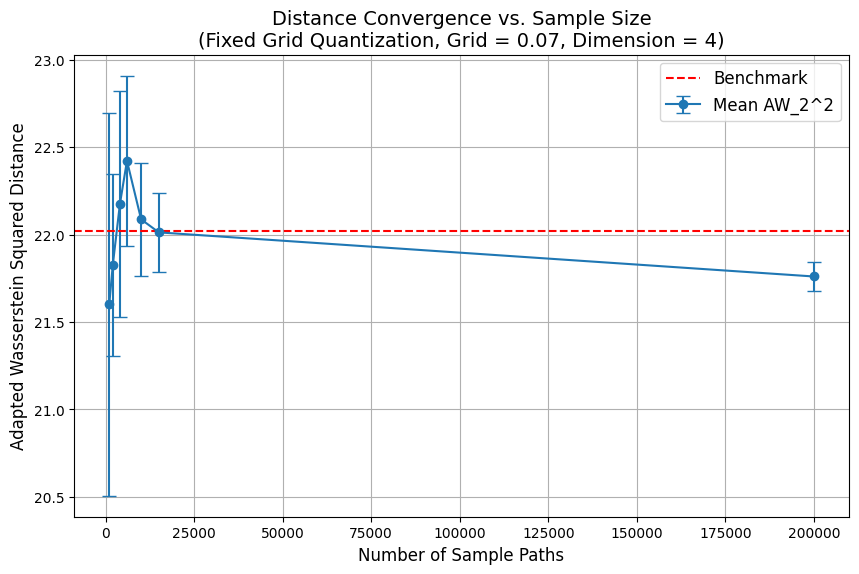

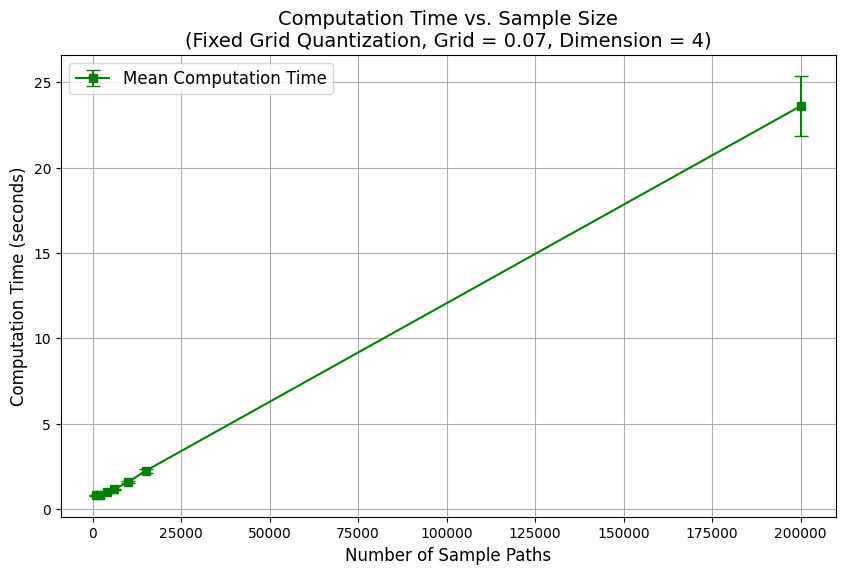

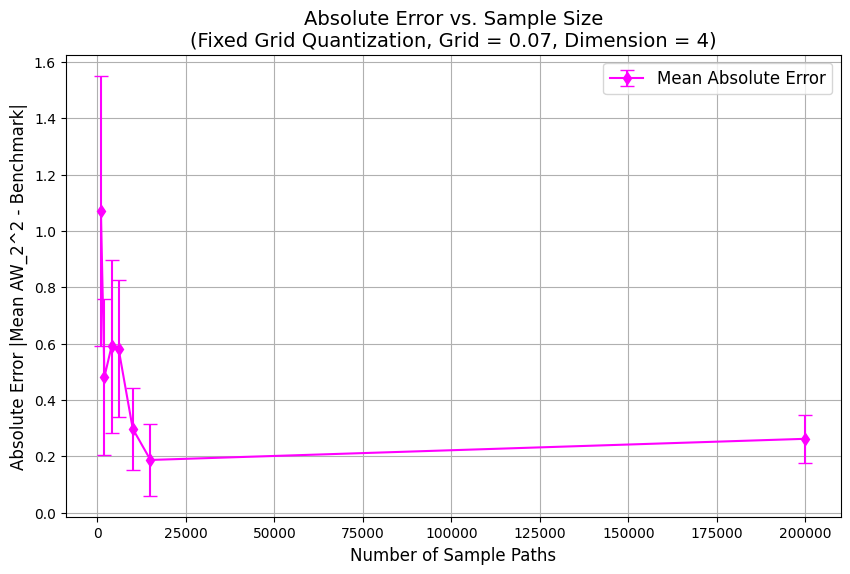

In [21]:
sample_list = sorted(aggregated.keys())
mean_distances = [aggregated[n]["mean_distance"] for n in sample_list]
std_distances = [aggregated[n]["std_distance"] for n in sample_list]
mean_times = [aggregated[n]["mean_time"] for n in sample_list]
std_times = [aggregated[n]["std_time"] for n in sample_list]
mean_abs_errors = [aggregated[n]["mean_abs_error"] for n in sample_list]
std_abs_errors = [aggregated[n]["std_abs_error"] for n in sample_list]
benchmark = aggregated[sample_list[0]]["benchmark"]  # assuming benchmark is the same across sizes

# Plot 1: Distance Convergence
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_distances, yerr=std_distances, fmt="o-", capsize=5, label="Mean AW_2^2")
plt.axhline(y=benchmark, color="red", linestyle="--", label="Benchmark")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Adapted Wasserstein Squared Distance", fontsize=12)
plt.title("Distance Convergence vs. Sample Size\n(Fixed Grid Quantization, Grid = 0.07, Dimension = 4)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot 2: Computation Time
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_times, yerr=std_times, fmt="s-", capsize=5, color="green", label="Mean Computation Time")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Computation Time (seconds)", fontsize=12)
plt.title("Computation Time vs. Sample Size\n(Fixed Grid Quantization, Grid = 0.07, Dimension = 4)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot 3: Absolute Error
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_abs_errors, yerr=std_abs_errors, fmt="d-", capsize=5, color="magenta", label="Mean Absolute Error")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Absolute Error |Mean AW_2^2 - Benchmark|", fontsize=12)
plt.title("Absolute Error vs. Sample Size\n(Fixed Grid Quantization, Grid = 0.07, Dimension = 4)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()